Use neural network to generate PID parameters. Neural network is trained using a model of the plant so we don't need to know jacobian of plant. Model is trained on plant outputs offline using LSTM.

Branched from V3.9

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import tensorflow as tf
from tensorflow.python.framework import ops

In [2]:
d_t = 0.01
d_t_decimal = str(d_t)[::-1].find('.')
steps = 3000

In [3]:
class PID:
    def __init__(self, Kp=0, Ki=0, Kd=0):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.I_max = 5
        self.e = 0
        self.t = 0
        self.e_prev = 0
        self.t_prev = 0
        self.P = 0
        self.I = 0
        self.D = 0
        self.u = 0
        
    def set_state(self, e, t):
        self.e = e
        self.t = t
        
    def update(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        
        delta_time = self.t - self.t_prev
        delta_error = self.e - self.e_prev
        
        self.P = e
        
        self.I += e * delta_time

        if (self.I < -self.I_max):
            self.I = -self.I_max
        elif (self.I > self.I_max):
            self.I = self.I_max

        if delta_time > 0:
            self.D = delta_error / delta_time
        else:
            self.D = 0

        self.t_prev = self.t
        self.e_prev = self.e

        self.u = self.Kp * self.P + self.Ki * self.I + self.Kd * self.D
        return np.float32(self.u)
        
    def d_update(self, Kp, Ki, Kd):
        return np.float32(self.P), np.float32(self.I), np.float32(self.D)
    
    def reset(self):
        self.e = 0
        self.t = 0
        self.e_prev = 0
        self.t_prev = 0
        self.P = 0
        self.I = 0
        self.D = 0
        self.u = 0


In [4]:
def plant_process(y, t, u):
    K = 0.01
    tau = 1.0
    T = 0.2
    
    t_delay = round(t-T, d_t_decimal)
    if (t_delay<= 0) or (t_delay<0.0):
        u_delay = u[0]
    else:
        step_t = int(t_delay/d_t)-1
        if step_t >= steps:
            u_delay = u[-1]
        else: 
            u_delay = u[step_t]  
        
    dydt = (-y + K*u_delay)/tau
    return dydt

def plant(y_0, t1, t2, u):
    ts = [t1, t2]
    return odeint(plant_process, y_0, ts, args=(u,))[1]

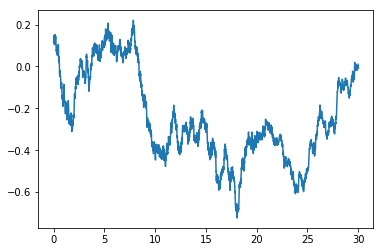

In [5]:
interval = 200
r_steps = steps//interval

r_sq = np.zeros(steps)
up = -1

for i in range(r_steps):
    if i < r_steps-1:
        r_sq[i * interval:(i+1)*interval] = up
    else:
        r_sq[i * interval:] = up
    if up > 0:
        up = -1
    else:
        up = 1

t = np.linspace(0, d_t*steps, steps)
r_sin = np.sin(t)

def gen_rand_sig(t):
    N = 1000
    x = np.random.normal(scale=10.0, size=len(t))
    return np.convolve(x, np.ones((N,))/N)[(N-1):] 
    
r_rand = gen_rand_sig(t)
plt.plot(t, r_rand)

### Plant control with neural network

In [26]:
pid = PID()

np_update = np.vectorize(pid.update)
np_d_update = np.vectorize(pid.d_update)

def tf_d_update(Kp, Ki, Kd,name=None):
    with tf.name_scope(name, "d_update", [Kp, Ki, Kd]) as name:
        y = tf.py_func(np_d_update,
                        [Kp, Ki, Kd],
                        (tf.float32, tf.float32, tf.float32),
                        name=name,
                        stateful=False)
        return y

def py_func(func, inp, Tout, stateful=True, name=None, grad=None):

    # Need to generate a unique name to avoid duplicates:
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+8))

    tf.RegisterGradient(rnd_name)(grad)  # see _MySquareGrad for grad example
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)
    
def updategrad(op, grad):
    Kp, Ki, Kd = op.inputs
    
    dudKp, dudKi, dudKd = tf_d_update(Kp, Ki, Kd)
    return grad * dudKp, grad * dudKi, grad * dudKd


def tf_update(Kp, Ki, Kd, name=None):

    with tf.name_scope(name, "update", [Kp, Ki, Kd]) as name:
        y = py_func(np_update,
                        [Kp, Ki, Kd],
                        [tf.float32],
                        name=name,
                        grad=updategrad)  # <-- here's the call to the gradient
        return y[0]


num_nodes = 64
input_size = 1

hp1 = 8
hp2 = 5
hp3 = 3

graph = tf.Graph()
with graph.as_default():
    
    tf_r = tf.placeholder(tf.float32,shape=())
    tf_y = tf.placeholder(tf.float32,shape=())
    tf_learning_rate = tf.placeholder(tf.float32, shape=())

              
   #LSTM
    # Forget gate: input, previous output, and bias.
    fx = tf.Variable(tf.truncated_normal([input_size, num_nodes]))
    fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes]))
    fb = tf.Variable(tf.zeros([1, num_nodes]))
    # Input gate: input, previous output, and bias.
    ix = tf.Variable(tf.truncated_normal([input_size, num_nodes]))
    im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes]))
    ib = tf.Variable(tf.zeros([1, num_nodes]))
    # Memory cell: input, state and bias.                             
    cx = tf.Variable(tf.truncated_normal([input_size, num_nodes]))
    cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes]))
    cb = tf.Variable(tf.zeros([1, num_nodes]))
    # Output gate: input, previous output, and bias.
    ox = tf.Variable(tf.truncated_normal([input_size, num_nodes]))
    om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes]))
    ob = tf.Variable(tf.zeros([1, num_nodes]))
    # Variables saving state across unrollings.
    saved_output = tf.Variable(tf.zeros([1, num_nodes]), trainable=False)
    saved_state = tf.Variable(tf.zeros([1, num_nodes]), trainable=False)
    # Classifier weights and biases.
    wm = tf.Variable(tf.truncated_normal([num_nodes, 1]))
    bm = tf.Variable(tf.zeros([1]))
    
    def lstm_cell(i, o, state):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates."""
        # i is the current input
        # o is the previous hidden state (i.e. h_t-1)
        # state is the previous state (i.e. C_t-1)
        x_weights = tf.concat([fx, ix, cx, ox], axis=1)
        m_weights = tf.concat([fm, im, cm, om], axis=1)
        
        matmul_i = tf.matmul(i, x_weights)
        matmul_o = tf.matmul(o, m_weights)
        
        # Determine what to forget based on input and prev output
        forget_gate = tf.sigmoid(
            matmul_i[:, :num_nodes] + matmul_o[:, :num_nodes] + fb)
        
        # Determine what to pass into state based on input and prev output
        input_gate = tf.sigmoid(
            matmul_i[:, num_nodes:num_nodes*2] + matmul_o[:, num_nodes:num_nodes*2] + ib)
      
        # Transform current input and prev output
        update = matmul_i[:, num_nodes*2:num_nodes*3] + matmul_o[:, num_nodes*2:num_nodes*3] + cb
        
        # Update state. 
        # Forget some of the state determined by the forget gate
        # Add part of input and prev output (Contained in update) determined by input gate
        # Update is in tanh to force between -1 and 1
        state = forget_gate * state + input_gate * tf.tanh(update)
        
        # Determine what to pass into output from state based on input and prev output
        output_gate = tf.sigmoid(
            matmul_i[:, num_nodes*3:num_nodes*4] + matmul_o[:, num_nodes*3:num_nodes*4] + ob)
        
        # Filter state with what was determined in the last step, and set it as the output
        return output_gate *  tf.tanh(state), state
        # i.e. return h_t, C_t
    
    def run_lstm(X):
        output = saved_output
        state = saved_state
        output, state = lstm_cell(tf.reshape(X, (1, 1)), output, state)

        # State saving across unrollings
        # This will save the state for the next batch
        with tf.control_dependencies([saved_output.assign(output),
                                     saved_state.assign(state)]):
            # Classifier.
            return tf.matmul(output, wm) + bm
    
    # PID param NN
    wpid_1 = tf.Variable(tf.truncated_normal([2, hp1]))
    bpid_1 = tf.Variable(tf.ones([hp1]))   
    wpid_2 = tf.Variable(tf.truncated_normal([hp1, hp2]))
    bpid_2 = tf.Variable(tf.ones([hp2]))
    wpid_3 = tf.Variable(tf.truncated_normal([hp2, hp3]))
    bpid_3 = tf.Variable(tf.ones([hp3]))
    wpid_4 = tf.Variable(tf.truncated_normal([hp3, 3]))
    bpid_4 = tf.Variable(tf.ones([3]))

 
    
    # Forward prop model offline
    y_model_offline = run_lstm(tf.reshape(tf_r, (1, 1)))
 
    # Forward prop PID
    X = tf.stack([tf_y, tf_r], 0) 
    
    z1 = tf.matmul(tf.reshape(X, (1, 2)), wpid_1) + bpid_1
    a1 = tf.nn.relu(z1)
    z2 = tf.matmul(a1, wpid_2) + bpid_2
    a2 = tf.nn.relu(z2)
    z3 = tf.matmul(a2, wpid_3) + bpid_3
    a3 = tf.nn.relu(z3)
    pid_params = tf.matmul(a3, wpid_4) + bpid_4
    Kp, Ki, Kd = tf.split(pid_params, 3, 1)
    
    Kp = tf.math.abs(Kp)
    Ki = tf.math.abs(Ki)
    Kd = tf.math.abs(Kd)
    
    u_nn = tf_update(Kp, Ki, Kd)
    
    # Forward prop model online
    y_model_online = run_lstm(u_nn)

    model_var_list = [fx, fm, fb, ix, im, ib, cx, cm, cb, ox, om, ob, wm, bm]
    model_loss = tf.losses.mean_squared_error(tf_y, tf.reshape(y_model_offline, ()))
    model_opt = tf.train.AdamOptimizer(tf_learning_rate).minimize(model_loss, var_list=model_var_list)

    pid_var_list = [wpid_1, bpid_1, wpid_2, bpid_2, wpid_3, bpid_3, wpid_4, bpid_4]
    pid_loss = tf.losses.mean_squared_error(tf_r, tf.reshape(y_model_online, ()))
    pid_opt = tf.train.AdamOptimizer(tf_learning_rate).minimize(pid_loss, var_list=pid_var_list)


In [27]:
epochs = 10

y_0 = 0
y_p_offline = np.zeros(steps)
y_m_offline = np.zeros(steps)

y_p_online = np.zeros(steps)
y_m_online = np.zeros(steps)
u_offline = np.zeros(steps)
u_online = np.zeros(steps)

Kp = np.zeros(steps)
Ki = np.zeros(steps)
Kd = np.zeros(steps)

offline_loss = np.zeros(steps * epochs)
online_loss = np.zeros(steps * epochs) 

def reset_offline():
    pid.reset()
    y_0 = 0
    
    y_p_offline = np.zeros(steps)
    y_m_offline = np.zeros(steps)
    u_offline = np.zeros(steps)


def reset_online():
    pid.reset()
    y_0 = 0
    
    y_p_online = np.zeros(steps)
    y_m_online = np.zeros(steps)
    u_online = np.zeros(steps)


r_offline = r_sq
r_online = r_sq


offline_lr = 0.01
online_lr = 0.01

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for j in range(epochs):
        reset_offline()
        print("Start epoch", j)
        session.run(saved_output.initializer)
        session.run(saved_state.initializer)
        for i in range(steps)[1:]:
            t_prev = t[i-1]
            t_cur = t[i]

            # Get plant output
            y_p_offline[i] = plant(y_0, t_prev, t_cur, r_offline)
            # Train model on plant output
            feed_dict = {tf_y:y_p_offline[i], tf_r:r_offline[i], tf_learning_rate:offline_lr}
            _, offline_loss[i + j*steps], y_m_offline[i] = session.run([model_opt, model_loss, y_model_offline], 
                                                             feed_dict=feed_dict)

            y_0 = y_p_offline[i]
            
        print("Offline loss", sum(offline_loss[:i + j*steps])/len(offline_loss[:i + j*steps]))

        reset_online()
        session.run(saved_output.initializer)
        session.run(saved_state.initializer)

        for i in range(steps)[1:]:  

            e = r_online[i] - y_p_online[i-1]
            t_prev = t[i-1]
            t_cur = t[i]
            pid.set_state(e, t_cur)

            # Get get PID parameters and get control signal
            # Send to model to train PID param NN
            feed_dict = {tf_y:y_p_online[i-1], tf_r:r_online[i], tf_learning_rate:online_lr}
            _, online_loss[i + j*steps], y_m_online[i], u_online[i] = session.run([pid_opt, pid_loss, y_model_online, u_nn], 
                                                    feed_dict=feed_dict)
            y_p_online[i] = plant(y_0, t_prev, t_cur, u_online)
            y_0 = y_p_online[i]
            
        print("Online loss", sum(online_loss[:i + j*steps])/len(online_loss[:i + j*steps]))

    #Test
    reset_online()
    for i in range(len(t))[1:]:  
        
        e = r_online[i] - y_p_online[i-1]
        t_prev = t[i-1]
        t_cur = t[i]
        pid.set_state(e, t_cur)
        
        # Get get PID parameters and get control signal
        # Send to model to train PID param NN
        feed_dict = {tf_y:y_p_online[i-1], tf_r:r_sq[i], tf_learning_rate:online_lr}
        y_m_online[i], u_online[i] = session.run([y_model_online, u_nn], feed_dict=feed_dict)
        Kp[i] = pid.Kp
        Ki[i] = pid.Ki
        Kd[i] = pid.Kd
        
        y_p_online[i] = plant(y_0, t_prev, t_cur, u_online)
        y_0 = y_p_online[i]

Start epoch 0
Offline loss 0.3608408129418037
Online loss 0.9956673756056047
Start epoch 1
Offline loss 0.18291262098117891
Online loss 1.077202291811219
Start epoch 2
Offline loss 0.1229566603617116
Online loss 1.0520322804898317
Start epoch 3
Offline loss 0.09223187710848535
Online loss 1.0380609778026315
Start epoch 4
Offline loss 0.07382922431224191
Online loss 1.02979384279522
Start epoch 5
Offline loss 0.061528121362846445
Online loss 1.0196520436059306
Start epoch 6
Offline loss 0.05273907815447045
Online loss 1.0150572722867988
Start epoch 7
Offline loss 0.046147093220676776
Online loss 1.053387820410084
Start epoch 8
Offline loss 0.041020494795594775
Online loss 1.115045873491665
Start epoch 9
Offline loss 0.03691981275536925
Online loss 1.1090462817241116


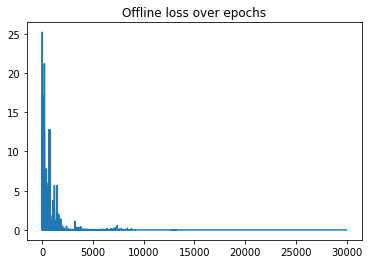

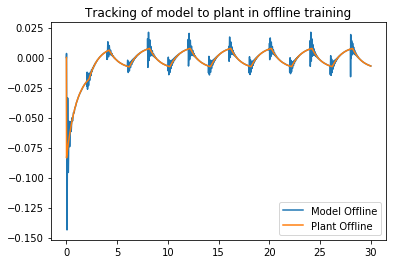

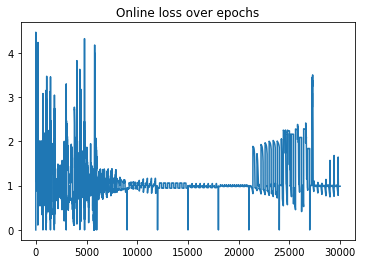

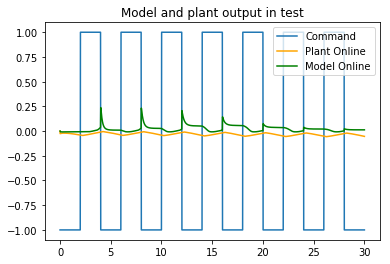

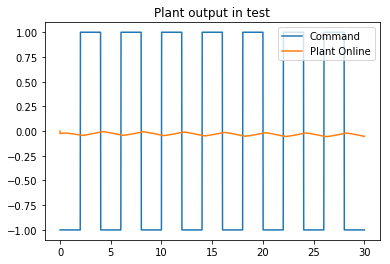

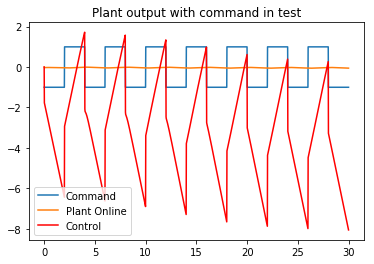

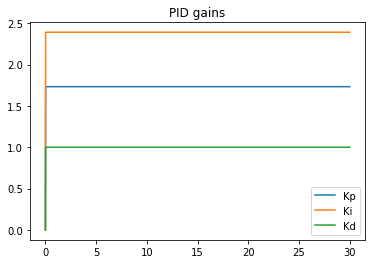

In [29]:
plt.plot(offline_loss)
plt.title('Offline loss over epochs')
plt.show()

plt.plot(t, y_m_offline)
plt.plot(t, y_p_offline)
plt.title('Tracking of model to plant in offline training')
plt.legend(('Model Offline', 'Plant Offline'))
plt.show()

plt.plot(online_loss)
plt.title('Online loss over epochs')
plt.show()

plt.plot(t, r_sq)
plt.plot(t, y_p_online, color='orange')
plt.plot(t, y_m_online, color='green')
plt.title('Model and plant output in test')
plt.legend(('Command', 'Plant Online', 'Model Online'))
plt.show()

plt.plot(t, r_sq)
plt.plot(t, y_p_online)
plt.title('Plant output in test')
plt.legend(('Command', 'Plant Online'))
plt.show()

plt.plot(t, r_sq)
plt.plot(t, y_p_online)
plt.plot(t, u_online, color='red')
plt.title('Plant output with command in test')
plt.legend(('Command', 'Plant Online', 'Control'))
plt.show()

plt.plot(t, Kp)
plt.plot(t, Ki)
plt.plot(t, Kd)
plt.title('PID gains')
plt.legend(('Kp', 'Ki', 'Kd'))
plt.show()